In [ ]:
# uncomment to install all requirements
# !pip install -r requirements.txt
# !pip install tensorboard
# import scipy
# print(scipy.__version__)
# Python 3.11.14

In [12]:
import scipy
print(scipy.__version__)

1.16.3


In [1]:
import mujoco
import mediapy as media
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.transform import Rotation as R
import gymnasium as gym
from stable_baselines3 import DDPG

In [13]:
model = mujoco.MjModel.from_xml_path("bitcraze_crazyflie_2/cf2.xml")

In [14]:
data = mujoco.MjData(model)

""

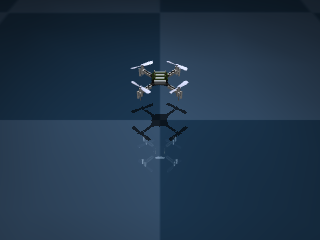

In [15]:
with mujoco.Renderer(model) as renderer:
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)

  media.show_image(renderer.render())

In [16]:
# define mass
model.body('cf2').mass[0]

np.float64(0.0347)

<h1 style="color:navy; text-decoration:underline;">PD Controller</h1>


In [17]:
def feedback_control(data):
    kp = 3.0
    kd = 1.0
    pos_desired = np.array([0.0, 0.0, 0.5])
    vel_desired = np.array([0.0, 0.0, 0.0])

    pos_error = pos_desired - data.qpos[0:3]
    vel_error = vel_desired - data.qvel[0:3]
    
    m = model.body('cf2').mass[0]
    force = kp * pos_error + kd * vel_error + np.array([0, 0, 9.81])
    thrust = m * force[2]  # only z-component

    return thrust

In [18]:
duration = 20  # (seconds)
framerate = 60  # (Hz)

# simulate and display video.
frames = []
t_l = []
qpos_l = []
qori_l = []

mujoco.mj_resetData(model, data)  # reset state and time.
with mujoco.Renderer(model, height = 480, width = 640) as renderer:
  while data.time < duration:
    data.actuator('body_thrust').ctrl = feedback_control(data)  # set body thrust (f_z) to hover
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      t_l.append(data.time)
      qpos_l.append(data.qpos.copy())
      qori_l.append(R.from_quat(data.qpos[3:7], scalar_first=True).as_euler('xyz'))

      renderer.update_scene(data, camera = 'track')
      pixels = renderer.render()
      frames.append(pixels)

t_l = np.array(t_l)
qpos_l = np.array(qpos_l)
qori_l = np.array(qori_l)
media.show_video(frames, fps=framerate)

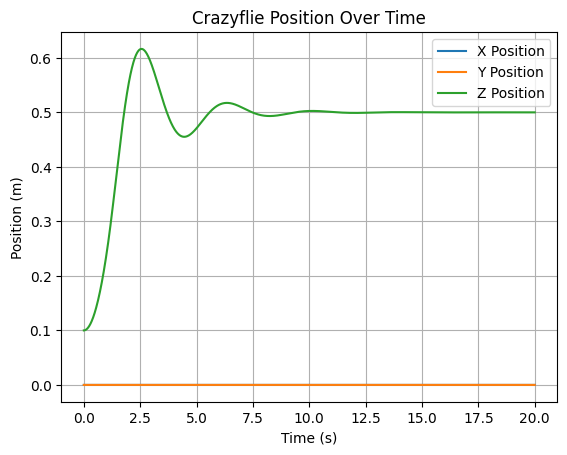

In [19]:
plt.plot(t_l, qpos_l[:, 0], label ="X Position")
plt.plot(t_l, qpos_l[:, 1], label ="Y Position")
plt.plot(t_l, qpos_l[:, 2], label ="Z Position")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.grid()
plt.title("Crazyflie Position Over Time")
plt.legend()

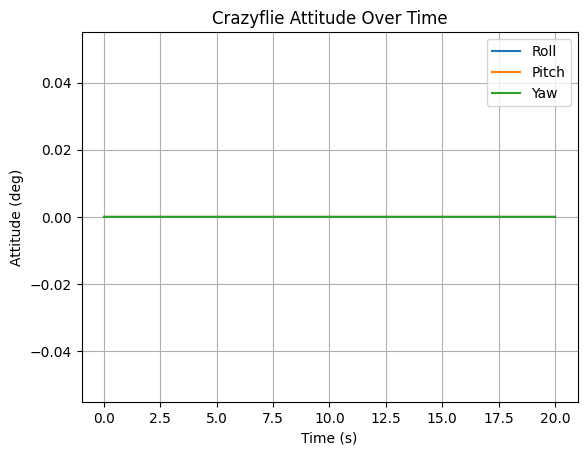

In [20]:
plt.plot(t_l, np.degrees(qori_l[:, 0]), label ="Roll") 
plt.plot(t_l, np.degrees(qori_l[:, 1]), label ="Pitch")
plt.plot(t_l, np.degrees(qori_l[:, 2]), label ="Yaw")
plt.xlabel("Time (s)")
plt.ylabel("Attitude (deg)")
plt.grid()
plt.title("Crazyflie Attitude Over Time")
plt.legend()

RMS Position Error (m): 0.08986894438714838


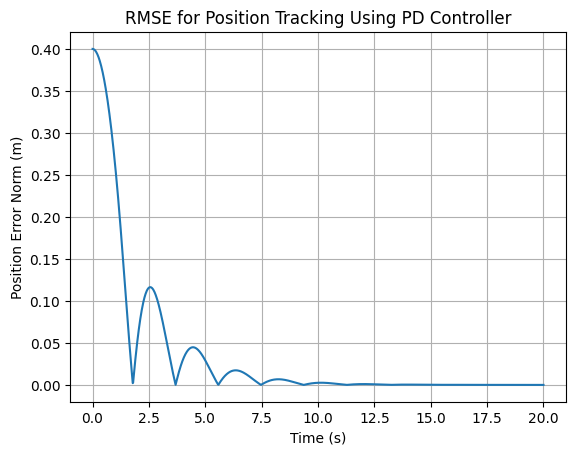

In [10]:
desired_pos = np.array([0.0, 0.0, 0.5])
error_norm = np.linalg.norm(qpos_l[:,:3] - desired_pos, axis = 1)
rms_error = np.sqrt(np.mean(error_norm**2))
plt.plot(t_l, error_norm)
plt.xlabel("Time (s)")
plt.ylabel("Position Error Norm (m)")
plt.grid()
plt.title("RMSE for Position Tracking Using PD Controller")
print("RMS Position Error (m):", rms_error)

<h1 style="color:navy; text-decoration:underline;">
Controller Based on the Lab 5 C Code for the Crazyflie Drone (Without Integral Action)
</h1>

In [11]:
# working hover code from C code:

# in integer format, has to be remapped to limits

# tau_x = 0.00491541f * (p_y - p_y_des) -0.00652343f * phi + 0.00264962f * v_y -0.00084121f * w_x;
# tau_y = -0.00491541f * (p_x - p_x_des) -0.00654763f * theta -0.00265419f * v_x -0.00084713f * w_y;
# tau_z = -0.00010906f * psi -0.00009983f * w_z;
# f_z = -0.17624202f * (p_z - p_z_des) -0.10988951f * v_z + 0.32373000f;

In [12]:
# original C code from Lab 5 controller:

def enforce_motor_limits(motor_commands):
    motor_commands = np.clip(motor_commands, [-1, -1, -1, 0], [1, 1, 1, 0.35])
    return motor_commands

def c_controller(data, desired_pos):
    p_x_des, p_y_des, p_z_des = desired_pos

    p_x, p_y, p_z = data.qpos[0:3]
    v_x, v_y, v_z = data.qvel[0:3]
    w_x, w_y, w_z = data.qvel[3:6]
    phi, theta, psi = R.from_quat(data.qpos[3:7], scalar_first=True).as_euler('xyz')

    tau_x = 0.00491541 * (p_y - p_y_des) -0.00652343 * phi + 0.00264962 * v_y -0.00084121 * w_x
    tau_y = -0.00491541 * (p_x - p_x_des) -0.00654763 * theta -0.00265419 * v_x -0.00084713 * w_y
    tau_z = -0.00010906 * psi -0.00009983 * w_z
    # original f_z from C code:
    f_z = -0.17624202 * (p_z - p_z_des) -0.10988951 * v_z + 0.32373000
    # adjusted f_z to account for steady state error observed:
    # f_z = -0.17624202 * (p_z - p_z_des) -0.10988951 * v_z + model.body('cf2').mass[0] * 9.81

    return enforce_motor_limits([tau_x, tau_y, tau_z, f_z])

    # do not need lines below because they are used simply for mapping onto cf2 motors

    # m_1 = -4676393.6 * tau_x -4676393.6 * tau_y -78864353.3 * tau_z + 154321.0 * f_z
    # m_2 = -4676393.6 * tau_x + 4676393.6 * tau_y + 78864353.3 * tau_z + 154321.0 * f_z
    # m_3 = 4676393.6 * tau_x + 4676393.6 * tau_y -78864353.3 * tau_z + 154321.0 * f_z
    # m_4 = 4676393.6 * tau_x -4676393.6 * tau_y + 78864353.3 * tau_z + 154321.0 * f_z

    # motor_commands = np.array([m_1, m_2, m_3, m_4])
    # motor_commands = np.clip(motor_commands, 0, 65535)


In [13]:
# controller based on C code:

duration = 20  # (seconds)
framerate = 60  # (Hz)

# simulate and display video.
frames = []
t_l = []
qpos_l = []
qori_l = []
u_l = []

mujoco.mj_resetData(model, data)  # reset state and time.
with mujoco.Renderer(model, height = 480, width = 640) as renderer:
    while data.time < duration:

        u = c_controller(data, desired_pos = np.array([0.0, 0.0, 0.5]))
        data.actuator('x_moment').ctrl = u[0]
        data.actuator('y_moment').ctrl = u[1]
        data.actuator('z_moment').ctrl = u[2]
        data.actuator('body_thrust').ctrl = u[3]
        

        mujoco.mj_step(model, data)
        if len(frames) < data.time * framerate:
            t_l.append(data.time)
            qpos_l.append(data.qpos.copy())
            qori_l.append(R.from_quat(data.qpos[3:7], scalar_first=True).as_euler('xyz'))
            u_l.append(u)

            renderer.update_scene(data, camera = 'track')
            pixels = renderer.render()
            frames.append(pixels)

t_l = np.array(t_l)
qpos_l = np.array(qpos_l)
qori_l = np.array(qori_l)
u_l = np.array(u_l)
media.show_video(frames, fps=framerate)

# The following plots show the controller without the integral action

## Note: Using the controller from Lab 5, we see that there is a steady state error (also observed by the drone in real life). Rather than reaching the desired position of $z = 0.5$ meters, the drone has a constant steady state error and only maintains an altitude of 0.4 meters. This prompts adding integral action or correcting for the bias in $f_z$ (it should be $mg$, but in the controller C code, it is smaller than that).

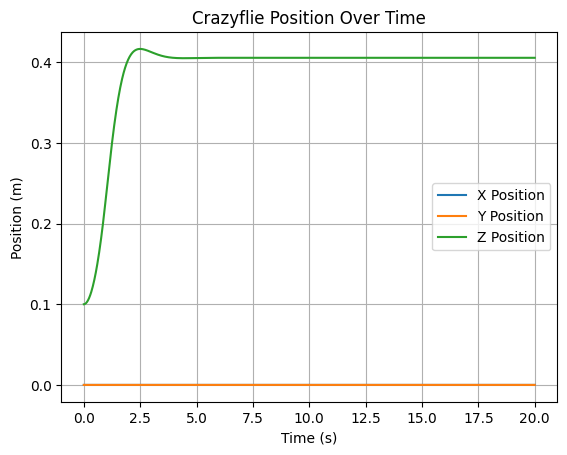

In [14]:
plt.plot(t_l, qpos_l[:, 0], label ="X Position")
plt.plot(t_l, qpos_l[:, 1], label ="Y Position")
plt.plot(t_l, qpos_l[:, 2], label ="Z Position")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.grid()
plt.title("Crazyflie Position Over Time") 
plt.legend()

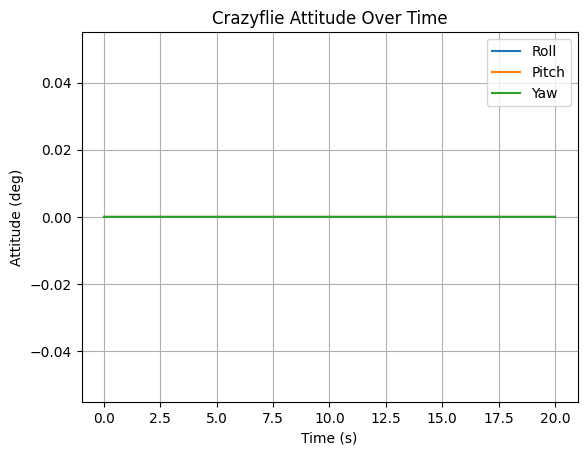

In [15]:
plt.plot(t_l, np.degrees(qori_l[:, 0]), label ="Roll") 
plt.plot(t_l, np.degrees(qori_l[:, 1]), label ="Pitch")
plt.plot(t_l, np.degrees(qori_l[:, 2]), label ="Yaw")
plt.xlabel("Time (s)")
plt.ylabel("Attitude (deg)")
plt.grid()
plt.title("Crazyflie Attitude Over Time")
plt.legend()

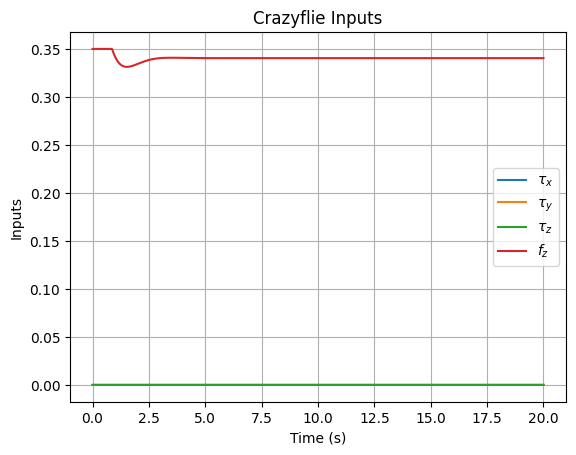

In [16]:
plt.plot(t_l, u_l[:, 0], label=r"$\tau_x$")
plt.plot(t_l, u_l[:, 1], label=r"$\tau_y$")
plt.plot(t_l, u_l[:, 2], label=r"$\tau_z$")
plt.plot(t_l, u_l[:, 3], label=r"$f_z$")
plt.xlabel("Time (s)")
plt.ylabel("Inputs")
plt.grid()
plt.title("Crazyflie Inputs")
plt.legend()


RMS Position Error (m) Without Integral Action: 0.1255830902904274


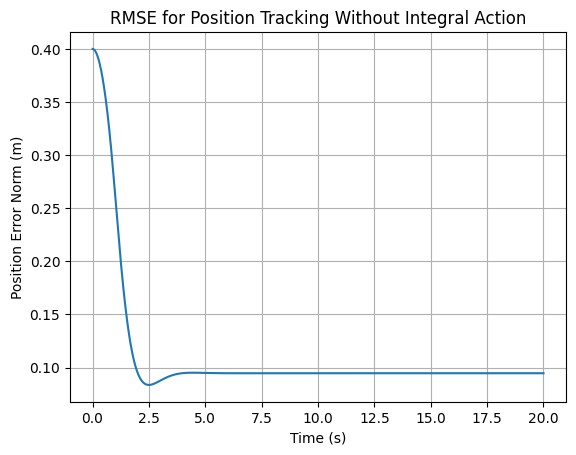

In [17]:
error_norm = np.linalg.norm(qpos_l[:,:3] - desired_pos, axis = 1)
rms_error = np.sqrt(np.mean(error_norm**2))
plt.plot(t_l, error_norm)
plt.xlabel("Time (s)")
plt.ylabel("Position Error Norm (m)")
plt.grid()
plt.title("RMSE for Position Tracking Without Integral Action")
print("RMS Position Error (m) Without Integral Action:", rms_error)

<h1 style="color:navy; text-decoration:underline;">
Plots showing the drone with integral action to correct the constant steady state error
</h1>


In [18]:
# original C code from Lab 5 -

def enforce_motor_limits(motor_commands):
    motor_commands = np.clip(motor_commands, [-1, -1, -1, 0], [1, 1, 1, 0.35]) # 0.35 is the motor limit in the .xml file
    return motor_commands

def c_controller(data, desired_pos):
    p_x_des, p_y_des, p_z_des = desired_pos

    p_x, p_y, p_z = data.qpos[0:3]
    v_x, v_y, v_z = data.qvel[0:3]
    w_x, w_y, w_z = data.qvel[3:6]
    phi, theta, psi = R.from_quat(data.qpos[3:7], scalar_first=True).as_euler('xyz')

    tau_x = 0.00491541 * (p_y - p_y_des) -0.00652343 * phi + 0.00264962 * v_y -0.00084121 * w_x
    tau_y = -0.00491541 * (p_x - p_x_des) -0.00654763 * theta -0.00265419 * v_x -0.00084713 * w_y
    tau_z = -0.00010906 * psi -0.00009983 * w_z
    # adjusted f_z to account for steady state error observed:
    f_z = -0.17624202 * (p_z - p_z_des) -0.10988951 * v_z + model.body('cf2').mass[0] * 9.81

    return enforce_motor_limits([tau_x, tau_y, tau_z, f_z])

    # do not need lines below bc used simply for mapping onto cf2 motors

    # m_1 = -4676393.6 * tau_x -4676393.6 * tau_y -78864353.3 * tau_z + 154321.0 * f_z
    # m_2 = -4676393.6 * tau_x + 4676393.6 * tau_y + 78864353.3 * tau_z + 154321.0 * f_z
    # m_3 = 4676393.6 * tau_x + 4676393.6 * tau_y -78864353.3 * tau_z + 154321.0 * f_z
    # m_4 = 4676393.6 * tau_x -4676393.6 * tau_y + 78864353.3 * tau_z + 154321.0 * f_z

    # motor_commands = np.array([m_1, m_2, m_3, m_4])
    # motor_commands = np.clip(motor_commands, 0, 65535)

In [19]:
# controller based on C code:

duration = 20  # (seconds)
framerate = 60  # (Hz)

# simulate and display video.
frames = []
t_l = []
qpos_l = []
qori_l = []
u_l = []

mujoco.mj_resetData(model, data)  # reset state and time.
with mujoco.Renderer(model, height = 480, width = 640) as renderer:
    while data.time < duration:

        u = c_controller(data, desired_pos = np.array([0.0, 0.0, 0.5]))
        data.actuator('x_moment').ctrl = u[0]
        data.actuator('y_moment').ctrl = u[1]
        data.actuator('z_moment').ctrl = u[2]
        data.actuator('body_thrust').ctrl = u[3]
        

        mujoco.mj_step(model, data)
        if len(frames) < data.time * framerate:
            t_l.append(data.time)
            qpos_l.append(data.qpos.copy())
            qori_l.append(R.from_quat(data.qpos[3:7], scalar_first=True).as_euler('xyz'))
            u_l.append(u)

            renderer.update_scene(data)
            pixels = renderer.render()
            frames.append(pixels)

t_l = np.array(t_l)
qpos_l = np.array(qpos_l)
qori_l = np.array(qori_l)
u_l = np.array(u_l)
media.show_video(frames, fps=framerate)

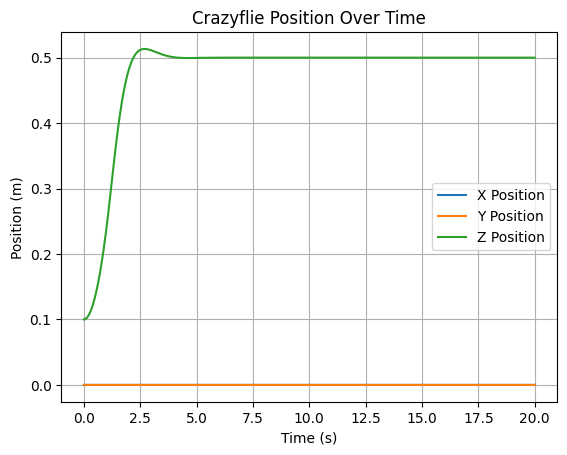

In [20]:
plt.plot(t_l, qpos_l[:, 0], label ="X Position")
plt.plot(t_l, qpos_l[:, 1], label ="Y Position")
plt.plot(t_l, qpos_l[:, 2], label ="Z Position")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.grid()
plt.title("Crazyflie Position Over Time") 
plt.legend()

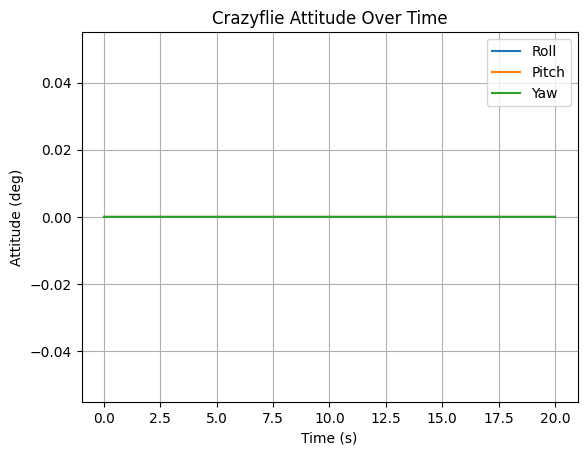

In [21]:
plt.plot(t_l, np.degrees(qori_l[:, 0]), label ="Roll") 
plt.plot(t_l, np.degrees(qori_l[:, 1]), label ="Pitch")
plt.plot(t_l, np.degrees(qori_l[:, 2]), label ="Yaw")
plt.xlabel("Time (s)")
plt.ylabel("Attitude (deg)")
plt.grid()
plt.title("Crazyflie Attitude Over Time")
plt.legend()

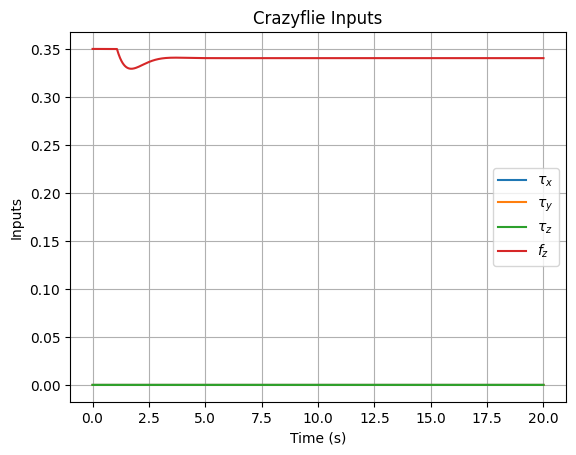

In [22]:
plt.plot(t_l, u_l[:, 0], label=r"$\tau_x$")
plt.plot(t_l, u_l[:, 1], label=r"$\tau_y$")
plt.plot(t_l, u_l[:, 2], label=r"$\tau_z$")
plt.plot(t_l, u_l[:, 3], label=r"$f_z$")
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Inputs")
plt.title("Crazyflie Inputs")
plt.legend()

RMS Position Error (m) for the Custom Controller with Integral Action: 0.0862812838669387


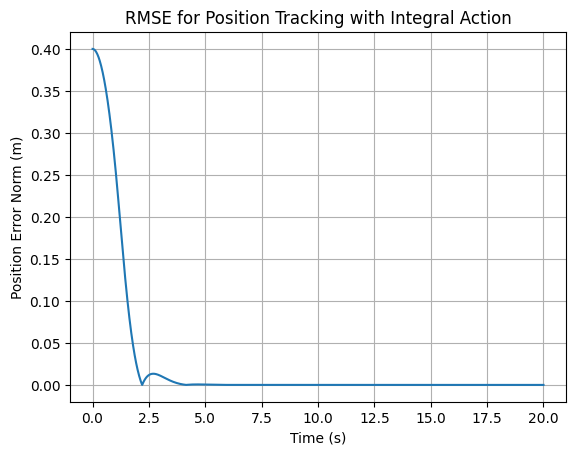

In [23]:
error_norm = np.linalg.norm(qpos_l[:,:3] - desired_pos, axis = 1)
rms_error = np.sqrt(np.mean(error_norm**2))
plt.plot(t_l, error_norm)
plt.xlabel("Time (s)")
plt.ylabel("Position Error Norm (m)")
plt.grid()
plt.title("RMSE for Position Tracking with Integral Action")
print("RMS Position Error (m) for the Custom Controller with Integral Action:", rms_error)

### As seen above, there is convergence with the RMSE of position tracking for the custom controller with integral action, showing minimal tracking error.

<h1 style="color:navy; text-decoration:underline;">
Testing the Robustness of the Lab 5 Controller By Introducing Perturbations
</h1>


In [24]:
def perturb_initial_state(data):
    # perturb orientation by small random angles

    angles = np.random.uniform(-0.01, 0.01, size=3)
    rot = R.from_euler('xyz', angles)
    current_rot = R.from_quat(data.qpos[3:7], scalar_first=True)
    new_rot = rot * current_rot
    data.qpos[3:7] = new_rot.as_quat(scalar_first=True)

In [25]:
def enforce_motor_limits(motor_commands):
    motor_commands = np.clip(motor_commands, [-1, -1, -1, 0], [1, 1, 1, 0.35]) # 0.35 is the motor limit in the .xml file
    return motor_commands

def c_controller(data, desired_pos):
    p_x_des, p_y_des, p_z_des = desired_pos

    p_x, p_y, p_z = data.qpos[0:3]
    v_x, v_y, v_z = data.qvel[0:3]
    w_x, w_y, w_z = data.qvel[3:6]
    phi, theta, psi = R.from_quat(data.qpos[3:7], scalar_first=True).as_euler('xyz')

    tau_x = 0.00491541 * (p_y - p_y_des) -0.00652343 * phi + 0.00264962 * v_y -0.00084121 * w_x
    tau_y = -0.00491541 * (p_x - p_x_des) -0.00654763 * theta -0.00265419 * v_x -0.00084713 * w_y
    tau_z = -0.00010906 * psi -0.00009983 * w_z
    # adjusted f_z to account for steady state error observed:
    f_z = -0.17624202 * (p_z - p_z_des) -0.10988951 * v_z + model.body('cf2').mass[0] * 9.81

    return enforce_motor_limits([tau_x, tau_y, tau_z, f_z])

In [26]:
duration = 20  # (seconds)
framerate = 60  # (Hz)

# simulate and display video.
frames = []
t_l = []
qpos_l = []
qori_l = []
u_l = []
desired_pos = np.array([0.0, 0.0, 0.5])

mujoco.mj_resetData(model, data)  # reset state and time.
perturb_initial_state(data)
with mujoco.Renderer(model, height = 480, width = 640) as renderer:
    while data.time < duration:

        u = c_controller(data, desired_pos)
        data.actuator('x_moment').ctrl = u[0] * -1e5
        data.actuator('y_moment').ctrl = u[1] * -1e5
        data.actuator('z_moment').ctrl = u[2] * -1e5
        data.actuator('body_thrust').ctrl = u[3]
        

        mujoco.mj_step(model, data)
        if len(frames) < data.time * framerate:
            t_l.append(data.time)
            qpos_l.append(data.qpos.copy())
            qori_l.append(R.from_quat(data.qpos[3:7], scalar_first=True).as_euler('xyz'))
            u_l.append(u)

            renderer.update_scene(data, camera = 'track')
            pixels = renderer.render()
            frames.append(pixels)

t_l = np.array(t_l)
qpos_l = np.array(qpos_l)
qori_l = np.array(qori_l)
u_l = np.array(u_l)
media.show_video(frames, fps=framerate)

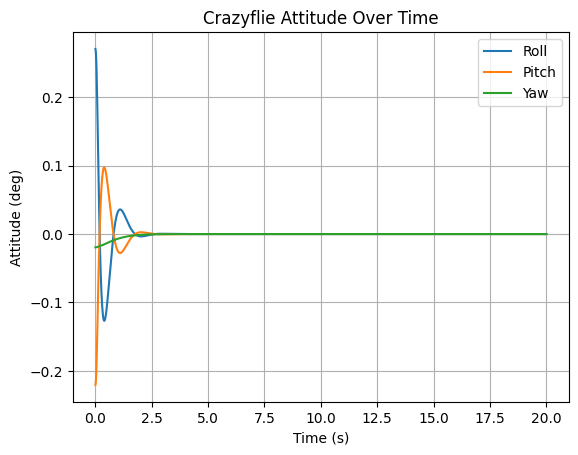

In [27]:
plt.plot(t_l, np.degrees(qori_l[:, 0]), label ="Roll") 
plt.plot(t_l, np.degrees(qori_l[:, 1]), label ="Pitch")
plt.plot(t_l, np.degrees(qori_l[:, 2]), label ="Yaw")
plt.xlabel("Time (s)")
plt.ylabel("Attitude (deg)")
plt.grid()
plt.title("Crazyflie Attitude Over Time")
plt.legend()

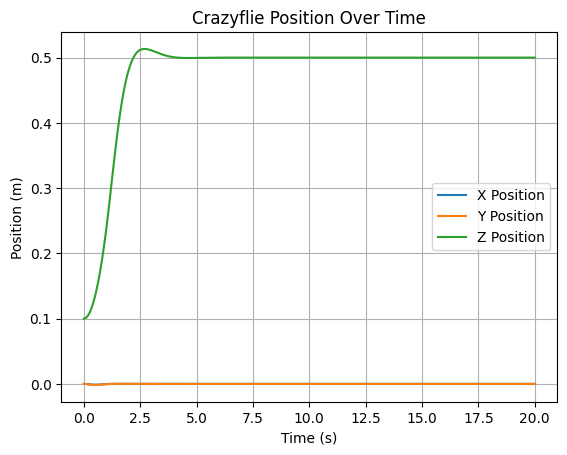

In [28]:
plt.plot(t_l, qpos_l[:, 0], label ="X Position")
plt.plot(t_l, qpos_l[:, 1], label ="Y Position")
plt.plot(t_l, qpos_l[:, 2], label ="Z Position")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.grid()
plt.title("Crazyflie Position Over Time") 
plt.legend()

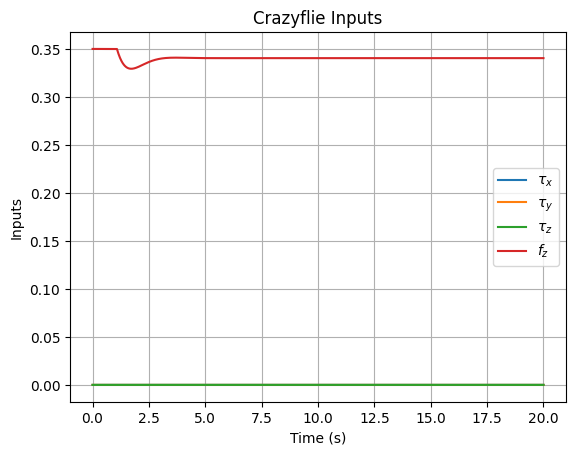

In [29]:
plt.plot(t_l, u_l[:, 0], label=r"$\tau_x$")
plt.plot(t_l, u_l[:, 1], label=r"$\tau_y$")
plt.plot(t_l, u_l[:, 2], label=r"$\tau_z$")
plt.plot(t_l, u_l[:, 3], label=r"$f_z$")
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("Inputs")
plt.title("Crazyflie Inputs")
plt.legend()

RMS Position Error (m) for the Custom Controller with Perturbations: 0.0862850793309946


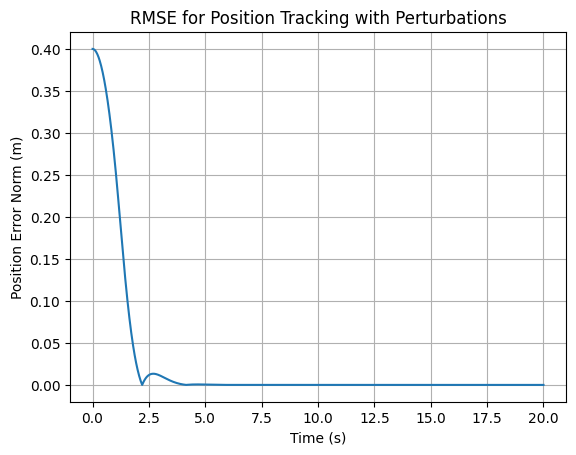

In [30]:
error_norm = np.linalg.norm(qpos_l[:,:3] - desired_pos, axis = 1)
rms_error = np.sqrt(np.mean(error_norm**2))
plt.plot(t_l, error_norm)
plt.xlabel("Time (s)")
plt.ylabel("Position Error Norm (m)")
plt.grid()
plt.title("RMSE for Position Tracking with Perturbations")
print("RMS Position Error (m) for the Custom Controller with Perturbations:", rms_error)

As seen above, the controller from Lab 5 is not robust to perturbations and requires further tuning.

<h1 style="color:navy; text-decoration:underline;">
Adding the Gym Environment
</h1>

In [144]:
# def backflip_reference(t, start_pos=[0.0, 0.0, 0.5], flip_height=1.0, duration=2.0):
#     """Compute backflip reference position and orientation at time t.
    
#     Args:
#         t: float, time in seconds
#         start_pos: list of 3 floats, starting position [x, y, z]
#         flip_height: float, maximum height of the flip
#         duration: float, total duration of the flip in seconds
    
#     Returns:
#         position: np.ndarray of shape (3,)
#         orientation: np.ndarray of shape (3,) in radians (roll, pitch, yaw)
#     """
#     if t < 0 or t > duration:
#         return np.array(start_pos), np.array([0.0, 0.0, 0.0])
    
#     # Vertical position follows a parabolic trajectory
#     if t <= duration / 2:
#         z = start_pos[2] + (4 * flip_height / duration**2) * t * (duration / 2 - t)
#     else:
#         z = start_pos[2]
    
#     position = np.array([start_pos[0], start_pos[1], z])
    
#     # Pitch angle follows a linear trajectory from 0 to 360 degrees
#     pitch = (360.0 / duration) * t
#     # pitch = 0
#     orientation = np.array([0.0, np.radians(pitch), 0.0])  # roll=0, yaw=0
    
#     return position, orientation

# def backflip_reference_trajectory(start_pos=[0.0, 0.0, 0.5], flip_height=1.0, duration=2.0, dt=1/60):
#     """Generate a backflip reference trajectory.
    
#     Returns:
#         times: np.ndarray of shape (N,)
#         positions: np.ndarray of shape (N, 3)
#         orientations: np.ndarray of shape (N, 3)
#     """
    
#     num_steps = int(duration / dt)
#     positions = np.zeros((num_steps, 3))
#     orientations = np.zeros((num_steps, 3))  # roll, pitch, yaw
#     times = np.linspace(0, duration, num_steps)
        
#     for i, t in enumerate(times):
#         pos, ori = backflip_reference(t, start_pos=start_pos, flip_height=flip_height, duration=duration)
#         positions[i] = pos
#         orientations[i] = ori

#     return times, positions, orientations

In [145]:
import numpy as np

def backflip_reference(t, start_pos=[0.0, 0.0, 0.5], flip_height=1.0, duration=2.0):
    """Compute backflip reference position and orientation at time t.

    Args:
        t: float, time in seconds
        start_pos: list of 3 floats, starting position [x, y, z]
        flip_height: float, maximum height gain relative to start
        duration: float, total duration of the flip in seconds

    Returns:
        position: np.ndarray of shape (3,)
        orientation: np.ndarray of shape (3,) in radians (roll, pitch, yaw)
    """
    if t < 0:
        return np.array(start_pos), np.array([0.0, 0.0, 0.0])
    elif t > duration:
        # return to start position and orientation
        return np.array(start_pos), np.array([0.0, 0.0, 0.0])
    
    # normalized time from 0 to 1
    tau = t / duration

    # Parabolic vertical trajectory: z = z0 + 4h * tau * (1 - tau)
    z = start_pos[2] + 4 * flip_height * tau * (1 - tau)

    # Constant x,y (stationary flip)
    x, y = start_pos[0], start_pos[1]

    # Pitch angle rotates full 360° backward (negative direction)
    pitch = -2 * np.pi * tau  # radians

    position = np.array([x, y, z])
    orientation = np.array([0.0, pitch, 0.0])  # roll=0, yaw=0

    return position, orientation


def backflip_reference_trajectory(start_pos=[0.0, 0.0, 0.5], flip_height=1.0, duration=2.0, dt=1/60):
    """Generate a backflip reference trajectory.

    Returns:
        times: np.ndarray of shape (N,)
        positions: np.ndarray of shape (N, 3)
        orientations: np.ndarray of shape (N, 3)
    """
    times = np.arange(0, duration + dt, dt)
    positions = np.zeros((len(times), 3))
    orientations = np.zeros((len(times), 3))

    for i, t in enumerate(times):
        pos, ori = backflip_reference(t, start_pos=start_pos, flip_height=flip_height, duration=duration)
        positions[i] = pos
        orientations[i] = ori

    return times, positions, orientations


In [146]:
ref_traj = backflip_reference_trajectory(duration = 20.0)
times, positions, orientations = ref_traj

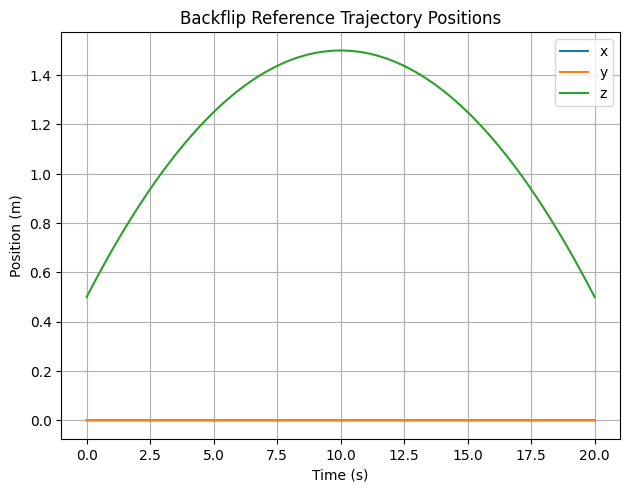

In [95]:
plt.plot(times, positions[:,0], label = "x")
plt.plot(times, positions[:,1], label = "y")
plt.plot(times, positions[:,2], label = "z")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.title("Backflip Reference Trajectory Positions")
plt.show()

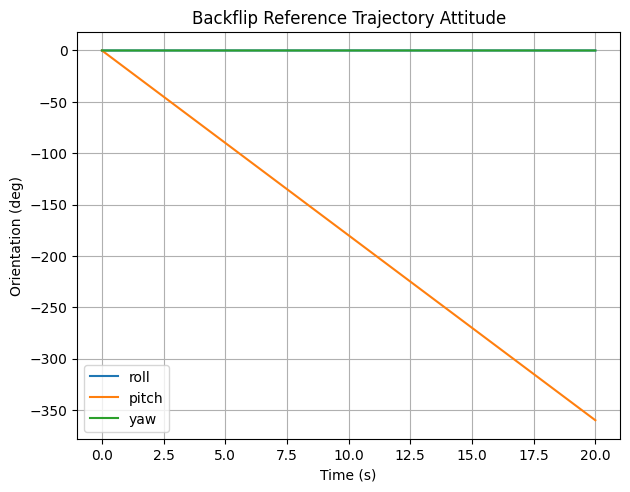

In [96]:
plt.plot(times, np.degrees(orientations[:,0]), label = "roll")
plt.plot(times, np.degrees(orientations[:,1]), label = "pitch")
plt.plot(times, np.degrees(orientations[:,2]), label = "yaw")
plt.xlabel("Time (s)")
plt.ylabel("Orientation (deg)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.title("Backflip Reference Trajectory Attitude")
plt.show()

In [47]:
# MOST RECENT ENVIRONMENT
class BackflipEnv(gym.Env):
    mg = 0.340407
    torque_scaling = 1
    action_space = gym.spaces.Box(low=np.array(3*[-torque_scaling] + [-mg]), high=np.array(3*[torque_scaling] + [0.35-mg]), shape=(4,), dtype=np.float32)
        
    obs_low = np.array([-np.inf]*12)
    obs_low[2] = 0.0  # z position must be non-negative
    obs_low[6:9] = -np.pi  # roll, pitch, yaw
    obs_high = np.array([np.inf]*12)
    obs_high[6:9] = np.pi  # roll, pitch, yaw
    observation_space = gym.spaces.Box(low=obs_low, high=obs_high, shape=(12,), dtype=np.float32)
    
    def __init__(self, start_position=[0.0, 0.0, 0.5], duration=10.0, flip_duration=4.0, dt=1/60, perturb_initial=True):
        super(BackflipEnv, self).__init__()
        self.duration = duration
        self.flip_duration = flip_duration
        self.dt = dt
        self.model = mujoco.MjModel.from_xml_path("bitcraze_crazyflie_2/cf2.xml")
        self.data = mujoco.MjData(self.model)
        self.current_step = 0
        self.num_steps = int(self.duration / self.dt)
        self.data.qpos[0:3] = np.array(start_position)
        self.start_pos = self.data.qpos[0:3].copy()
        
        self.perturb_initial = perturb_initial
        if self.perturb_initial:
            self.perturb_initial_state()
            
        mujoco.mj_forward(self.model, self.data)
        
    def render(self, mode='human'):
        with mujoco.Renderer(self.model, height=480, width=640) as renderer:
            renderer.update_scene(self.data, camera='track')
            pixels = renderer.render()
            return pixels
            
    def reset(self, *, seed = None, options = None):
        super().reset(seed=seed)
        mujoco.mj_resetData(self.model, self.data)
        self.data.qpos[0:3] = self.start_pos.copy()
        if self.perturb_initial:
            self.perturb_initial_state()
        self.current_step = 0
        return self.get_state(), {}

    def step(self, action):
        action = enforce_motor_limits(action)
        self.data.actuator('x_moment').ctrl = action[0] * -1e5
        self.data.actuator('y_moment').ctrl = action[1] * -1e5
        self.data.actuator('z_moment').ctrl = action[2] * -1e5
        self.data.actuator('body_thrust').ctrl = action[3] + BackflipEnv.mg
        
        while self.data.time < (self.current_step + 1) * self.dt:
            mujoco.mj_step(self.model, self.data)

        self.current_step += 1
        
        state = self.get_state()
        reward = self.compute_reward()
        terminated = self.current_step >= self.num_steps
        truncated = self.has_crashed()
        
        return state, reward, terminated, truncated, {}
    
    def has_crashed(self):
        return self.data.qpos[2] < 0.01
            
    def get_state(self):
        pos = self.data.qpos[0:3].copy()
        ori = R.from_quat(self.data.qpos[3:7], scalar_first=True).as_euler('xyz')
        vel = self.data.qvel[0:3].copy()
        ang_vel = self.data.qvel[3:6].copy()
        return np.concatenate([pos, ori, vel, ang_vel])
            
    def get_reference(self, t):
        pos, ori = backflip_reference(t, start_pos=self.start_pos, flip_height=1.0, duration=self.flip_duration)
        return pos, ori
    
    def get_tracking_error(self):
        t = self.current_step * self.dt
        ref_pos, ref_ori = self.get_reference(t)
        current_pos = self.data.qpos[0:3]
        current_ori = R.from_quat(self.data.qpos[3:7], scalar_first=True).as_euler('xyz')
        
        pos_error = np.abs(current_pos - ref_pos)
        ori_error = np.abs(current_ori - ref_ori)
        
        return pos_error, ori_error
    
    def compute_reward(self):
        pos_error, ori_error = self.get_tracking_error()
        reward = - np.sum(pos_error + ori_error) # added a term to scale ori_error
        return reward
            
    def perturb_initial_state(self):
        angles = np.random.uniform(-0.001, 0.001, size=3)
        rot = R.from_euler('xyz', angles)
        current_rot = R.from_quat(self.data.qpos[3:7], scalar_first=True)
        new_rot = rot * current_rot
        self.data.qpos[3:7] = new_rot.as_quat(scalar_first=True)


/Users/aaliyahgaffey/483_RL/.conda/lib/python3.11/site-packages/gymnasium/spaces/box.py:236: UserWarning: WARN: Box low's precision lowered by casting to float32, current low.dtype=float64
  gym.logger.warn(
/Users/aaliyahgaffey/483_RL/.conda/lib/python3.11/site-packages/gymnasium/spaces/box.py:306: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [48]:
# PREVIOUS:

env = BackflipEnv(perturb_initial=False, flip_duration=20.0, duration=20.0)
ddpg = DDPG("MlpPolicy", env, verbose=1)
ddpg.learn(total_timesteps=10_000)  # adjust timesteps as needed

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.2e+03  |
|    ep_rew_mean     | -1.7e+04 |
| time/              |          |
|    episodes        | 4        |
|    fps             | 238      |
|    time_elapsed    | 20       |
|    total_timesteps | 4800     |
| train/             |          |
|    actor_loss      | 191      |
|    critic_loss     | 3.31     |
|    learning_rate   | 0.001    |
|    n_updates       | 4699     |
---------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 1.2e+03   |
|    ep_rew_mean     | -1.56e+04 |
| time/              |           |
|    episodes        | 8         |
|    fps             | 235       |
|    time_elapsed    | 40        |
|    total_timesteps | 9600      |
| train/             |           |
|    actor_loss      | 307       |
|    critic

In [49]:
env.get_state()

array([-4.59831732e+00,  4.45649981e+00,  1.84716652e-02,  3.14155581e+00,
        6.75128088e-06,  1.29864157e+00, -6.11746070e-05, -3.81816272e-05,
        2.81141584e-05, -2.70390084e-03,  2.94243174e-03,  2.26151606e-04])

In [50]:
ddpg.predict(env.get_state(), deterministic=True)

(array([ 1.        , -1.        ,  1.        ,  0.00959301], dtype=float32),
 None)

In [52]:
env = BackflipEnv(perturb_initial=False)
env.render_mode = 'human'

vec_env = BackflipEnv(perturb_initial=False)
obs, _ = vec_env.reset()
vec_env.render_mode = 'human'
frames = []

for _ in range(vec_env.num_steps):
    action, _states = ddpg.predict(obs, deterministic=True)
    obs, rewards, dones, truncated, info = vec_env.step(action)
    frame = vec_env.render(mode = 'human')
    frames.append(frame)

env.close()
media.show_video(frames, fps=60)

# NEW RL for Backflip:

In [ ]:
# import tensorboard
# print(tensorboard.__version__)

In [ ]:
# tensorboard --logdir ./ddpg_backflip_logs --port 6006

In [ ]:
# ============================================================
# Crazyflie Backflip Simulation with DDPG in MuJoCo + TensorBoard
# ============================================================

from gymnasium import spaces
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.monitor import Monitor



# ============================================================
# Helper: wrap angle to [-pi, pi]
# ============================================================
def wrap_to_pi(x):
    return (x + np.pi) % (2 * np.pi) - np.pi


# ============================================================
# Helper: backflip reference trajectory
# ============================================================
def backflip_reference(t, start_pos=[0.0, 0.0, 0.5], flip_height=1.0, duration=2.0):
    """Compute backflip reference position and orientation at time t."""
    if t < 0:
        return np.array(start_pos), np.array([0.0, 0.0, 0.0])
    elif t > duration:
        return np.array(start_pos), np.array([0.0, 0.0, 0.0])

    tau = t / duration
    z = start_pos[2] + 4 * flip_height * tau * (1 - tau)  # parabolic rise/fall
    x, y = start_pos[0], start_pos[1]
    pitch = -2 * np.pi * tau  # one full backward rotation
    return np.array([x, y, z]), np.array([0.0, pitch, 0.0])


# ============================================================
# Environment Definition
# ============================================================
class BackflipEnv(gym.Env):
    """
    Crazyflie backflip environment for MuJoCo + SB3 DDPG.
    """

    metadata = {"render_modes": ["human"], "render_fps": 60}

    def __init__(
        self,
        start_position=(0.0, 0.0, 0.5),
        duration=4.0,
        flip_duration=2.0,
        dt=1/60,
        model_path="bitcraze_crazyflie_2/cf2.xml",
        torque_limit=0.03,
        pos_penalty_w=2.0,
        ori_penalty_w=0.5,
        angvel_penalty_w=0.1,
        final_bonus=100.0,
    ):
        super().__init__()

        # Timing
        self.dt = float(dt)
        self.duration = float(duration)
        self.flip_duration = float(flip_duration)
        self.num_steps = int(np.round(self.duration / self.dt))
        self.current_step = 0

        # Physics
        self.mg = 0.340407  # hover thrust ≈ mg

        # Load MuJoCo model
        self.model = mujoco.MjModel.from_xml_path(model_path)
        self.data = mujoco.MjData(self.model)

        # Initial state
        self.data.qpos[0:3] = np.array(start_position, dtype=float)
        self.start_pos = self.data.qpos[0:3].copy()
        mujoco.mj_forward(self.model, self.data)

        # Action space: [τx, τy, τz, thrust_offset]
        self.torque_limit = float(torque_limit)
        thrust_low = -self.mg
        thrust_high = 0.35 - self.mg
        low = np.array([-self.torque_limit, -self.torque_limit, -self.torque_limit, thrust_low], dtype=np.float32)
        high = np.array([self.torque_limit, self.torque_limit, self.torque_limit, thrust_high], dtype=np.float32)
        self.action_space = spaces.Box(low=low, high=high, dtype=np.float32)

        # Observation space: [pos(3), euler(3), vel(3), ang_vel(3)]
        obs_low = np.array([-np.inf]*12, dtype=np.float32)
        obs_low[2] = 0.0
        obs_low[6:9] = -np.pi
        obs_high = np.array([np.inf]*12, dtype=np.float32)
        obs_high[6:9] = np.pi
        self.observation_space = spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)

        # Reward weights
        self.pos_penalty_w = float(pos_penalty_w)
        self.ori_penalty_w = float(ori_penalty_w)
        self.angvel_penalty_w = float(angvel_penalty_w)
        self.final_bonus = float(final_bonus)

    # ---------- Gym API ----------
    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        mujoco.mj_resetData(self.model, self.data)
        self.data.qpos[0:3] = self.start_pos.copy()
        self.data.qvel[:] = 0.0
        self.current_step = 0
        mujoco.mj_forward(self.model, self.data)
        return self.get_state(), {}

    def step(self, action):
        action = np.asarray(action, dtype=np.float32)
        action = np.clip(action, self.action_space.low, self.action_space.high)

        # Apply actuators (cancel XML scaling)
        self.data.actuator("x_moment").ctrl = float(action[0]) * -1e5
        self.data.actuator("y_moment").ctrl = float(action[1]) * -1e5
        self.data.actuator("z_moment").ctrl = float(action[2]) * -1e5
        self.data.actuator("body_thrust").ctrl = float(action[3] + self.mg)

        # Integrate to next step
        target_time = (self.current_step + 1) * self.dt
        while self.data.time < target_time:
            mujoco.mj_step(self.model, self.data)
        self.current_step += 1

        obs = self.get_state()
        reward = self.compute_reward()
        terminated = self.current_step >= self.num_steps
        truncated = self.has_crashed()
        return obs, reward, terminated, truncated, {}

    def render(self, mode="human"):
        with mujoco.Renderer(self.model, height=480, width=640) as renderer:
            renderer.update_scene(self.data, camera="track")
            return renderer.render()

    # ---------- Helpers ----------
    def has_crashed(self):
        return bool(self.data.qpos[2] < 0.01)

    def get_state(self):
        pos = self.data.qpos[0:3].copy()
        eul = R.from_quat(self.data.qpos[3:7], scalar_first=True).as_euler("xyz")
        eul = np.array([wrap_to_pi(eul[0]), wrap_to_pi(eul[1]), wrap_to_pi(eul[2])])
        vel = self.data.qvel[0:3].copy()
        ang_vel = self.data.qvel[3:6].copy()
        obs = np.concatenate([pos, eul, vel, ang_vel]).astype(np.float32)
        return np.clip(obs, self.observation_space.low, self.observation_space.high)

    def get_reference(self, t):
        return backflip_reference(
            t, start_pos=self.start_pos, flip_height=1.0, duration=self.flip_duration
        )

    def get_tracking_error(self):
        t = self.current_step * self.dt
        ref_pos, ref_ori = self.get_reference(t)
        cur_pos = self.data.qpos[0:3].copy()
        cur_eul = R.from_quat(self.data.qpos[3:7], scalar_first=True).as_euler("xyz")
        cur_eul = np.array([wrap_to_pi(cur_eul[0]), wrap_to_pi(cur_eul[1]), wrap_to_pi(cur_eul[2])])
        pos_err = np.abs(cur_pos - ref_pos)
        ang_err = np.abs([wrap_to_pi(cur_eul[i] - ref_ori[i]) for i in range(3)])
        return pos_err, ang_err

    def compute_reward(self):
        pos_err, ang_err = self.get_tracking_error()
        ang_vel = np.linalg.norm(self.data.qvel[3:6])
        reward = -(
            self.pos_penalty_w * np.sum(pos_err)
            + self.ori_penalty_w * np.sum(ang_err)
            + self.angvel_penalty_w * ang_vel
        )

        # Terminal bonus for success
        if self.current_step >= self.num_steps:
            t = self.current_step * self.dt
            ref_pos, ref_ori = self.get_reference(t)
            cur_pos = self.data.qpos[0:3]
            cur_eul = R.from_quat(self.data.qpos[3:7], scalar_first=True).as_euler("xyz")
            pitch_err = abs(wrap_to_pi(cur_eul[1] - ref_ori[1]))
            if np.all(np.abs(cur_pos - ref_pos) < 0.10) and pitch_err < np.deg2rad(6.0):
                reward += self.final_bonus
        return float(reward)


# ============================================================
# DDPG Training + Logging
# ============================================================
if __name__ == "__main__":

    # Create environment
    env = BackflipEnv(flip_duration=2.0, duration=4.0)
    env = Monitor(env)

    # Add exploration noise
    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

    # Initialize DDPG with TensorBoard log directory
    ddpg = DDPG(
        "MlpPolicy",
        env,
        verbose=1,
        learning_rate=1e-3,
        buffer_size=200_000,
        learning_starts=10_000,
        batch_size=256,
        tau=0.005,
        gamma=0.98,
        train_freq=(1, "episode"),
        gradient_steps=64,
        action_noise=action_noise,
        tensorboard_log="./ddpg_backflip_logs/"  #  base log directory
    )

    # Train and save logs under a named run
    ddpg.learn(total_timesteps=50_000, log_interval=10, tb_log_name="DDPG_no_perturb")  # shorter run for testing
    ddpg.save("ddpg_backflip_model")

    # ============================================================
    # Post-training visualization
    # ============================================================
    obs, _ = env.reset()
    for _ in range(env.env.num_steps):   # note the .env
        action, _ = ddpg.predict(obs, deterministic=True)
        obs, reward, terminated, truncated, info = env.step(action)
        frame = env.render()
        if terminated or truncated:
            break





In [ ]:
model = DDPG.load("ddpg_backflip_model")  # adjust path if saved elsewhere

# Create a fresh environment (unwrapped, for rendering)
env = BackflipEnv(flip_duration=2.0, duration=4.0)
env.render_mode = 'human'

# Reset environment
obs, _ = env.reset()
frames = []

# ============================================================
# Run one full rollout (deterministic policy)
# ============================================================
for _ in range(env.num_steps):
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    frame = env.render(mode='human')
    frames.append(frame)
    if terminated or truncated:
        break

env.close()

# ============================================================
# Display video
# ============================================================
media.show_video(frames, fps=60)

# NEW RL: Oscillations

Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to ./ddpg_oscillation_logs/DDPG_pitch_oscillation_30_s_2
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 38.7     |
|    ep_rew_mean     | 18.1     |
| time/              |          |
|    episodes        | 10       |
|    fps             | 5344     |
|    time_elapsed    | 0        |
|    total_timesteps | 387      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.9     |
|    ep_rew_mean     | 18.1     |
| time/              |          |
|    episodes        | 20       |
|    fps             | 5538     |
|    time_elapsed    | 0        |
|    total_timesteps | 757      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 37.4     |
|    ep_rew_mean     | 18       |
| time/              |          |
|    episodes        | 30       |

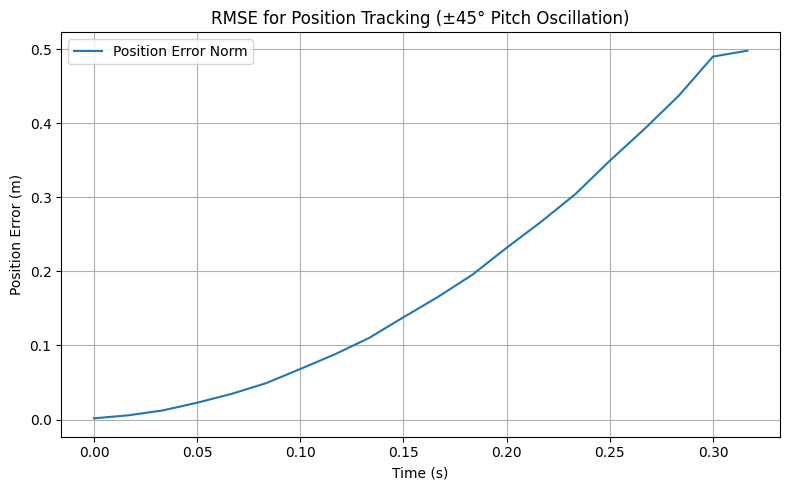

RMS Position Error (m): 0.2534


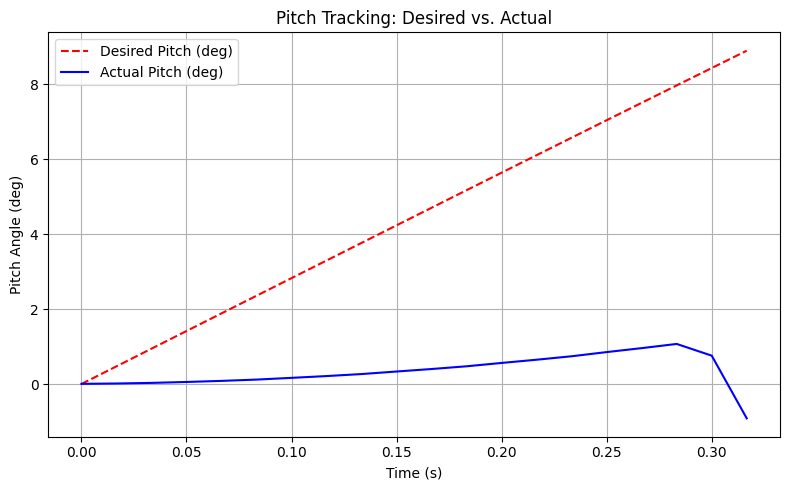

In [ ]:
# # ============================================================
# # Crazyflie ±45° Pitch Oscillation with DDPG in MuJoCo + TensorBoard + RMSE Plot
# # ============================================================

# import numpy as np
# import mujoco
# from gymnasium import spaces
# import gymnasium as gym
# from scipy.spatial.transform import Rotation as R
# from stable_baselines3 import DDPG
# from stable_baselines3.common.noise import NormalActionNoise
# from stable_baselines3.common.monitor import Monitor
# import mediapy as media
# import matplotlib.pyplot as plt


# # ============================================================
# # Helper: wrap angle to [-pi, pi]
# # ============================================================
# def wrap_to_pi(x):
#     return (x + np.pi) % (2 * np.pi) - np.pi


# # ============================================================
# # Helper: sinusoidal pitch reference (±amp_deg)
# # ============================================================
# def oscillation_reference(
#     t,
#     start_pos=[0.0, 0.0, 0.5],
#     amp_deg=45.0,
#     freq=0.1,      # 0.5 Hz → one full cycle every 10 s
# ):
#     """Continuous sinusoidal ±amp_deg pitch oscillation."""
#     amp_rad = np.deg2rad(amp_deg)
#     x, y, z = start_pos
#     pitch = amp_rad * np.sin(2 * np.pi * freq * t)
#     return np.array([x, y, z]), np.array([0.0, pitch, 0.0])


# # ============================================================
# # Environment Definition
# # ============================================================
# class OscillationEnv(gym.Env):
#     """
#     Crazyflie ±45° pitch oscillation environment for MuJoCo + SB3 DDPG.
#     """

#     metadata = {"render_modes": ["human"], "render_fps": 60}

#     def __init__(
#         self,
#         start_position=(0.0, 0.0, 0.5),
#         duration=30.0,
#         dt=1 / 60,
#         model_path="bitcraze_crazyflie_2/cf2.xml",
#         torque_limit=0.03,
#         pos_penalty_w=1.0,
#         ori_penalty_w=2.0,
#         angvel_penalty_w=0.1,
#         final_bonus=50.0,
#     ):
#         super().__init__()

#         # Timing
#         self.dt = float(dt)
#         self.duration = float(duration)
#         self.num_steps = int(np.round(self.duration / self.dt))
#         self.current_step = 0

#         # Physics
#         self.mg = 0.340407  # hover thrust ≈ mg

#         # Load MuJoCo model
#         self.model = mujoco.MjModel.from_xml_path(model_path)
#         self.data = mujoco.MjData(self.model)

#         # Initial state
#         self.data.qpos[0:3] = np.array(start_position, dtype=float)
#         self.start_pos = self.data.qpos[0:3].copy()
#         mujoco.mj_forward(self.model, self.data)

#         # Action space: [τx, τy, τz, thrust_offset]
#         self.torque_limit = float(torque_limit)
#         thrust_low = -self.mg
#         thrust_high = 0.6 - self.mg  # allow a bit more upward thrust
#         low = np.array(
#             [-self.torque_limit, -self.torque_limit, -self.torque_limit, thrust_low],
#             dtype=np.float32,
#         )
#         high = np.array(
#             [self.torque_limit, self.torque_limit, self.torque_limit, thrust_high],
#             dtype=np.float32,
#         )
#         self.action_space = spaces.Box(low=low, high=high, dtype=np.float32)

#         # Observation space: [pos(3), euler(3), vel(3), ang_vel(3)]
#         obs_low = np.array([-np.inf] * 12, dtype=np.float32)
#         obs_low[2] = 0.0
#         obs_low[6:9] = -np.pi
#         obs_high = np.array([np.inf] * 12, dtype=np.float32)
#         obs_high[6:9] = np.pi
#         self.observation_space = spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)

#         # Reward weights
#         self.pos_penalty_w = float(pos_penalty_w)
#         self.ori_penalty_w = float(ori_penalty_w)
#         self.angvel_penalty_w = float(angvel_penalty_w)
#         self.final_bonus = float(final_bonus)

#     # ---------- Gym API ----------
#     def reset(self, *, seed=None, options=None):
#         super().reset(seed=seed)
#         mujoco.mj_resetData(self.model, self.data)
#         self.data.qpos[0:3] = self.start_pos.copy()
#         self.data.qvel[:] = 0.0
#         self.current_step = 0
#         mujoco.mj_forward(self.model, self.data)
#         return self.get_state(), {}

#     def step(self, action):
#         action = np.asarray(action, dtype=np.float32)
#         action = np.clip(action, self.action_space.low, self.action_space.high)

#         # Apply actuators (cancel XML scaling)
#         self.data.actuator("x_moment").ctrl = float(action[0]) * -1e5
#         self.data.actuator("y_moment").ctrl = float(action[1]) * -1e5
#         self.data.actuator("z_moment").ctrl = float(action[2]) * -1e5
#         self.data.actuator("body_thrust").ctrl = float(action[3] + self.mg)

#         # Integrate to next step
#         target_time = (self.current_step + 1) * self.dt
#         while self.data.time < target_time:
#             mujoco.mj_step(self.model, self.data)
#         self.current_step += 1

#         obs = self.get_state()
#         reward = self.compute_reward()
#         terminated = self.current_step >= self.num_steps
#         truncated = self.has_crashed()
#         return obs, reward, terminated, truncated, {}

#     def render(self, mode="human"):
#         with mujoco.Renderer(self.model, height=480, width=640) as renderer:
#             renderer.update_scene(self.data, camera="track")
#             return renderer.render()

#     # ---------- Helpers ----------
#     def has_crashed(self):
#         return bool(self.data.qpos[2] < 0.01)

#     def get_state(self):
#         pos = self.data.qpos[0:3].copy()
#         eul = R.from_quat(self.data.qpos[3:7], scalar_first=True).as_euler("xyz")
#         eul = np.array([wrap_to_pi(eul[0]), wrap_to_pi(eul[1]), wrap_to_pi(eul[2])])
#         vel = self.data.qvel[0:3].copy()
#         ang_vel = self.data.qvel[3:6].copy()
#         obs = np.concatenate([pos, eul, vel, ang_vel]).astype(np.float32)
#         return np.clip(obs, self.observation_space.low, self.observation_space.high)

#     def get_reference(self, t):
#         return oscillation_reference(t, start_pos=self.start_pos)

#     def get_tracking_error(self):
#         t = self.current_step * self.dt
#         ref_pos, ref_ori = self.get_reference(t)
#         cur_pos = self.data.qpos[0:3].copy()
#         cur_eul = R.from_quat(self.data.qpos[3:7], scalar_first=True).as_euler("xyz")
#         cur_eul = np.array(
#             [wrap_to_pi(cur_eul[0]), wrap_to_pi(cur_eul[1]), wrap_to_pi(cur_eul[2])]
#         )
#         pos_err = np.abs(cur_pos - ref_pos)
#         ang_err = np.abs([wrap_to_pi(cur_eul[i] - ref_ori[i]) for i in range(3)])
#         return pos_err, ang_err

#     def compute_reward(self):
#         pos_err, ang_err = self.get_tracking_error()
#         ang_vel = np.linalg.norm(self.data.qvel[3:6])
#         reward = (
#             1.0
#             - self.pos_penalty_w * np.sum(pos_err)
#             - self.ori_penalty_w * np.sum(ang_err)
#             - self.angvel_penalty_w * ang_vel
#         )
#         # Bonus at end if close to reference
#         if self.current_step >= self.num_steps:
#             t = self.current_step * self.dt
#             ref_pos, ref_ori = self.get_reference(t)
#             cur_pos = self.data.qpos[0:3]
#             cur_eul = R.from_quat(self.data.qpos[3:7], scalar_first=True).as_euler("xyz")
#             pitch_err = abs(wrap_to_pi(cur_eul[1] - ref_ori[1]))
#             if np.all(np.abs(cur_pos - ref_pos) < 0.05) and pitch_err < np.deg2rad(10):
#                 reward += self.final_bonus
#         return float(reward)


# # ============================================================
# # Training + Visualization + RMSE Plot
# # ============================================================
# if __name__ == "__main__":
#     # Create environment with monitor for TensorBoard
#     env = OscillationEnv(duration=10.0)
#     env = Monitor(env)

#     # Add exploration noise
#     n_actions = env.action_space.shape[-1]
#     action_noise = NormalActionNoise(
#         mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions)
#     )

#     # Initialize DDPG with TensorBoard log directory
#     ddpg = DDPG(
#         "MlpPolicy",
#         env,
#         verbose=1,
#         learning_rate=1e-3,
#         buffer_size=200_000,
#         learning_starts=10_000,
#         batch_size=256,
#         tau=0.005,
#         gamma=0.98,
#         train_freq=(1, "episode"),
#         gradient_steps=64,
#         action_noise=action_noise,
#         tensorboard_log="./ddpg_oscillation_logs/",
#     )

#     # Train (short run for demo — increase to 200k+ for better performance)
#     ddpg.learn(
#         total_timesteps=50_000, log_interval=10, tb_log_name="DDPG_pitch_oscillation_30_s"
#     )
#     ddpg.save("ddpg_pitch_oscillation_model")

#     # ============================================================
#     # Post-training visualization and RMSE analysis
#     # ============================================================
#     model = DDPG.load("ddpg_pitch_oscillation_model")
#     env_vis = OscillationEnv(duration=30.0)
#     env_vis.render_mode = "human"

#     obs, _ = env_vis.reset()
#     frames = []
#     qpos_list, desired_pos_list, desired_pitch_list, actual_pitch_list = [], [], [], []
#     t_list = []

#     for step in range(env_vis.num_steps):
#         t = step * env_vis.dt
#         ref_pos, ref_ori = env_vis.get_reference(t)

#         action, _ = model.predict(obs, deterministic=True)
#         obs, reward, terminated, truncated, info = env_vis.step(action)
#         frame = env_vis.render(mode="human")

#         # Record data
#         qpos_list.append(env_vis.data.qpos[:3].copy())
#         desired_pos_list.append(ref_pos)
#         desired_pitch_list.append(ref_ori[1])
#         cur_eul = R.from_quat(env_vis.data.qpos[3:7], scalar_first=True).as_euler("xyz")
#         actual_pitch_list.append(cur_eul[1])
#         t_list.append(t)
#         frames.append(frame)

#         if terminated or truncated:
#             break

#     env_vis.close()
#     media.show_video(frames, fps=60)

#     # ============================================================
#     # Compute RMSE (Position)
#     # ============================================================
#     qpos_arr = np.array(qpos_list)
#     desired_pos_arr = np.array(desired_pos_list)
#     error_norm = np.linalg.norm(qpos_arr - desired_pos_arr, axis=1)
#     rms_error = np.sqrt(np.mean(error_norm**2))

#     plt.figure(figsize=(8, 5))
#     plt.plot(t_list, error_norm, label="Position Error Norm")
#     plt.xlabel("Time (s)")
#     plt.ylabel("Position Error (m)")
#     plt.title("RMSE for Position Tracking (±45° Pitch Oscillation)")
#     plt.grid(True)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

#     print(f"RMS Position Error (m): {rms_error:.4f}")

#     # ============================================================
#     # Pitch angle comparison
#     # ============================================================
#     plt.figure(figsize=(8, 5))
#     plt.plot(t_list, np.rad2deg(desired_pitch_list), "r--", label="Desired Pitch (deg)")
#     plt.plot(t_list, np.rad2deg(actual_pitch_list), "b", label="Actual Pitch (deg)")
#     plt.xlabel("Time (s)")
#     plt.ylabel("Pitch Angle (deg)")
#     plt.title("Pitch Tracking: Desired vs. Actual")
#     plt.grid(True)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to ./ddpg_oscillation_logs/DDPG_pitch_sine_5s_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 42.4     |
|    ep_rew_mean     | 3.97     |
| time/              |          |
|    episodes        | 10       |
|    fps             | 4182     |
|    time_elapsed    | 0        |
|    total_timesteps | 424      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 40       |
|    ep_rew_mean     | 4.81     |
| time/              |          |
|    episodes        | 20       |
|    fps             | 4704     |
|    time_elapsed    | 0        |
|    total_timesteps | 801      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 40.3     |
|    ep_rew_mean     | 4.61     |
| time/              |          |
|    episodes        | 30       |
|    fps

RMS Position Error (m): 3.6725


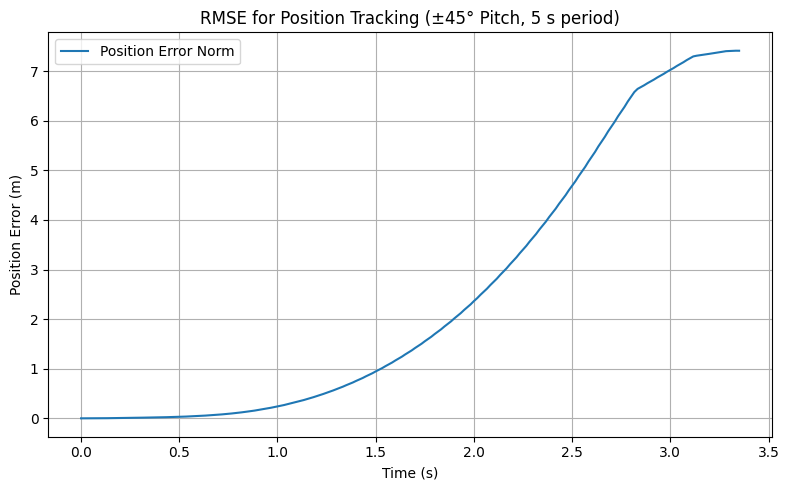

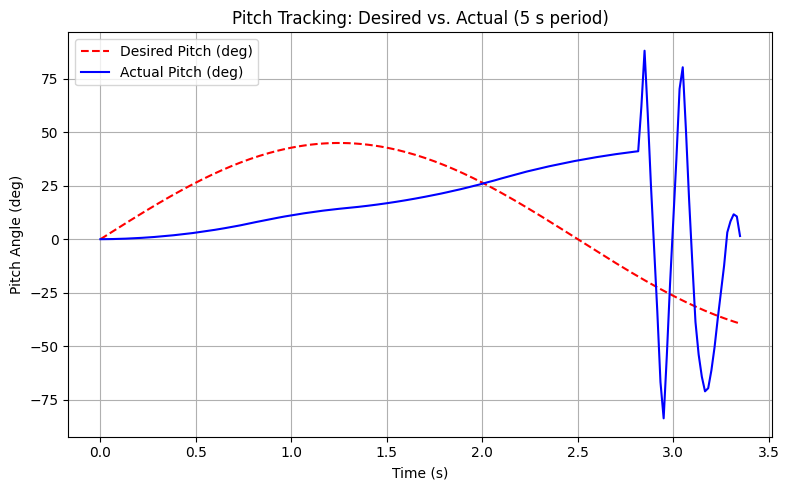

In [ ]:
# # ============================================================
# # Crazyflie ±45° Pitch Oscillation (5 s period) with DDPG
# # MuJoCo + TensorBoard + RMSE plots
# # ============================================================

# import numpy as np
# import mujoco
# from gymnasium import spaces
# import gymnasium as gym
# from scipy.spatial.transform import Rotation as R
# from stable_baselines3 import DDPG
# from stable_baselines3.common.noise import NormalActionNoise
# from stable_baselines3.common.monitor import Monitor
# import mediapy as media
# import matplotlib.pyplot as plt

# # -------------------- knobs --------------------
# OSC_AMP_DEG   = 45.0      # ±45° pitch
# OSC_FREQ_HZ   = 0.2       # 1 cycle / 5 s  ← IMPORTANT
# TRAIN_DUR_S   = 10.0      # 2 full cycles during training
# EVAL_DUR_S    = 10.0      # 2 full cycles during eval video
# DT            = 1/60      # 60 Hz physics
# LOG_DIR       = "./ddpg_oscillation_logs/"
# MODEL_PATH    = "ddpg_pitch_oscillation_model"
# XML_PATH      = "bitcraze_crazyflie_2/cf2.xml"  # adjust if needed

# # ============================================================
# # Helpers
# # ============================================================

# def wrap_to_pi(x):
#     return (x + np.pi) % (2 * np.pi) - np.pi

# def oscillation_reference(t, start_pos=(0.0, 0.0, 0.5),
#                           amp_deg=OSC_AMP_DEG,
#                           freq=OSC_FREQ_HZ):
#     """
#     Continuous sinusoidal ±amp_deg pitch oscillation.
#     One full cycle takes T = 1/f seconds. With freq=0.2 Hz, T=5 s.
#     """
#     amp_rad = np.deg2rad(amp_deg)
#     x, y, z = start_pos
#     pitch = amp_rad * np.sin(2 * np.pi * freq * t)
#     return np.array([x, y, z]), np.array([0.0, pitch, 0.0])

# # ============================================================
# # Environment
# # ============================================================

# class OscillationEnv(gym.Env):
#     """
#     Crazyflie ±amp pitch oscillation around hover (z≈0.5 m).
#     Actions: [τx, τy, τz, thrust_offset]; policy adds offset to mg.
#     Observations: [pos(3), euler_xyz(3), lin_vel(3), ang_vel(3)].
#     """

#     metadata = {"render_modes": ["human"], "render_fps": 60}

#     def __init__(self,
#                  start_position=(0.0, 0.0, 0.5),
#                  duration=TRAIN_DUR_S,
#                  dt=DT,
#                  model_path=XML_PATH,
#                  torque_limit=0.03,
#                  pos_penalty_w=1.2,
#                  ori_penalty_w=2.0,
#                  angvel_penalty_w=0.08,
#                  final_bonus=50.0):
#         super().__init__()

#         # Timing
#         self.dt = float(dt)
#         self.duration = float(duration)
#         self.num_steps = int(np.round(self.duration / self.dt))
#         self.current_step = 0

#         # Physics (hover thrust ~ mg from your earlier value)
#         self.mg = 0.340407

#         # MuJoCo
#         self.model = mujoco.MjModel.from_xml_path(model_path)
#         self.data = mujoco.MjData(self.model)

#         # Initial state
#         self.data.qpos[0:3] = np.array(start_position, dtype=float)
#         self.start_pos = self.data.qpos[0:3].copy()
#         mujoco.mj_forward(self.model, self.data)

#         # Action space: [τx, τy, τz, thrust_offset]
#         self.torque_limit = float(torque_limit)
#         thrust_low = -self.mg                     # allow negative offset
#         thrust_high = 0.7 - self.mg               # a bit more headroom
#         low = np.array([-self.torque_limit, -self.torque_limit, -self.torque_limit, thrust_low], dtype=np.float32)
#         high = np.array([ self.torque_limit,  self.torque_limit,  self.torque_limit, thrust_high], dtype=np.float32)
#         self.action_space = spaces.Box(low=low, high=high, dtype=np.float32)

#         # Observation space
#         obs_low = np.array([-np.inf]*12, dtype=np.float32)
#         obs_low[2] = 0.0
#         obs_low[6:9] = -np.pi
#         obs_high = np.array([np.inf]*12, dtype=np.float32)
#         obs_high[6:9] = np.pi
#         self.observation_space = spaces.Box(low=obs_low, high=obs_high, dtype=np.float32)

#         # Reward weights
#         self.pos_penalty_w   = float(pos_penalty_w)
#         self.ori_penalty_w   = float(ori_penalty_w)
#         self.angvel_penalty_w= float(angvel_penalty_w)
#         self.final_bonus     = float(final_bonus)

#     # ---------- Gym API ----------
#     def reset(self, *, seed=None, options=None):
#         super().reset(seed=seed)
#         mujoco.mj_resetData(self.model, self.data)
#         self.data.qpos[0:3] = self.start_pos.copy()
#         self.data.qvel[:] = 0.0
#         self.current_step = 0
#         mujoco.mj_forward(self.model, self.data)
#         return self.get_state(), {}

#     def step(self, action):
#         action = np.asarray(action, dtype=np.float32)
#         action = np.clip(action, self.action_space.low, self.action_space.high)

#         # Apply actuators (note: negate to cancel XML scaling if needed)
#         self.data.actuator("x_moment").ctrl = float(action[0]) * -1e5
#         self.data.actuator("y_moment").ctrl = float(action[1]) * -1e5
#         self.data.actuator("z_moment").ctrl = float(action[2]) * -1e5
#         self.data.actuator("body_thrust").ctrl = float(action[3] + self.mg)

#         # Integrate
#         target_time = (self.current_step + 1) * self.dt
#         while self.data.time < target_time:
#             mujoco.mj_step(self.model, self.data)
#         self.current_step += 1

#         obs = self.get_state()
#         reward = self.compute_reward()
#         terminated = self.current_step >= self.num_steps
#         truncated = self.has_crashed()
#         return obs, reward, terminated, truncated, {}

#     def render(self, mode="human"):
#         with mujoco.Renderer(self.model, height=480, width=640) as renderer:
#             renderer.update_scene(self.data, camera="track")
#             return renderer.render()

#     # ---------- Helpers ----------
#     def has_crashed(self):
#         # if z drops near ground, stop episode
#         return bool(self.data.qpos[2] < 0.02)

#     def get_state(self):
#         pos = self.data.qpos[0:3].copy()
#         eul = R.from_quat(self.data.qpos[3:7], scalar_first=True).as_euler("xyz")
#         eul = np.array([wrap_to_pi(eul[0]), wrap_to_pi(eul[1]), wrap_to_pi(eul[2])])
#         vel = self.data.qvel[0:3].copy()
#         ang_vel = self.data.qvel[3:6].copy()
#         obs = np.concatenate([pos, eul, vel, ang_vel]).astype(np.float32)
#         return np.clip(obs, self.observation_space.low, self.observation_space.high)

#     def get_reference(self, t):
#         return oscillation_reference(t, start_pos=tuple(self.start_pos))

#     def get_tracking_error(self):
#         t = self.current_step * self.dt
#         ref_pos, ref_ori = self.get_reference(t)
#         cur_pos = self.data.qpos[0:3].copy()
#         cur_eul = R.from_quat(self.data.qpos[3:7], scalar_first=True).as_euler("xyz")
#         cur_eul = np.array([wrap_to_pi(cur_eul[0]), wrap_to_pi(cur_eul[1]), wrap_to_pi(cur_eul[2])])
#         pos_err = np.abs(cur_pos - ref_pos)
#         ang_err = np.abs([wrap_to_pi(cur_eul[i] - ref_ori[i]) for i in range(3)])
#         return pos_err, ang_err

#     def compute_reward(self):
#         pos_err, ang_err = self.get_tracking_error()
#         ang_vel = np.linalg.norm(self.data.qvel[3:6])

#         # small positive base keeps gradient informative at start
#         reward = (
#             1.0
#             - self.pos_penalty_w * np.sum(pos_err)
#             - self.ori_penalty_w * np.sum(ang_err)
#             - self.angvel_penalty_w * ang_vel
#         )

#         # Terminal bonus if close at end
#         if self.current_step >= self.num_steps:
#             t = self.current_step * self.dt
#             ref_pos, ref_ori = self.get_reference(t)
#             cur_pos = self.data.qpos[0:3]
#             cur_eul = R.from_quat(self.data.qpos[3:7], scalar_first=True).as_euler("xyz")
#             pitch_err = abs(wrap_to_pi(cur_eul[1] - ref_ori[1]))
#             if np.all(np.abs(cur_pos - ref_pos) < 0.05) and pitch_err < np.deg2rad(10):
#                 reward += self.final_bonus
#         return float(reward)

# # ============================================================
# # Train + Visualize + RMSE
# # ============================================================

# if __name__ == "__main__":
#     # ---------- Training env (wrapped for SB3 logging) ----------
#     train_env = OscillationEnv(duration=TRAIN_DUR_S, dt=DT, model_path=XML_PATH)
#     train_env = Monitor(train_env)

#     # Exploration noise
#     n_actions = train_env.action_space.shape[-1]
#     action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

#     ddpg = DDPG(
#         "MlpPolicy",
#         train_env,
#         verbose=1,
#         learning_rate=1e-3,
#         buffer_size=200_000,
#         learning_starts=10_000,
#         batch_size=256,
#         tau=0.005,
#         gamma=0.98,
#         train_freq=(1, "episode"),
#         gradient_steps=64,
#         action_noise=action_noise,
#         tensorboard_log=LOG_DIR,
#     )

#     # NOTE: increase timesteps for better tracking once plumbing is confirmed
#     ddpg.learn(total_timesteps=50_000, log_interval=10, tb_log_name="DDPG_pitch_sine_5s")
#     ddpg.save(MODEL_PATH)

#     # ---------- Evaluation env (UNWRAPPED) ----------
#     model = DDPG.load(MODEL_PATH)
#     env_vis = OscillationEnv(duration=EVAL_DUR_S, dt=DT, model_path=XML_PATH)
#     env_vis.render_mode = "human"

#     obs, _ = env_vis.reset()
#     frames = []
#     qpos_list, desired_pos_list, desired_pitch_list, actual_pitch_list = [], [], [], []
#     t_list = []

#     for step in range(env_vis.num_steps):
#         t = step * env_vis.dt
#         ref_pos, ref_ori = env_vis.get_reference(t)

#         action, _ = model.predict(obs, deterministic=True)
#         obs, reward, terminated, truncated, _ = env_vis.step(action)
#         frame = env_vis.render(mode="human")

#         # Record
#         qpos_list.append(env_vis.data.qpos[:3].copy())
#         desired_pos_list.append(ref_pos)
#         desired_pitch_list.append(ref_ori[1])
#         cur_eul = R.from_quat(env_vis.data.qpos[3:7], scalar_first=True).as_euler("xyz")
#         actual_pitch_list.append(cur_eul[1])
#         t_list.append(t)
#         frames.append(frame)

#         if terminated or truncated:
#             # If you crash early, the video/plots will be short.
#             # Train longer or soften penalties if this happens repeatedly.
#             break

#     env_vis.close()
#     media.show_video(frames, fps=int(1/DT))

#     # ---------- RMSE: position ----------
#     qpos_arr = np.array(qpos_list)
#     desired_pos_arr = np.array(desired_pos_list)
#     error_norm = np.linalg.norm(qpos_arr - desired_pos_arr, axis=1)
#     rms_error = np.sqrt(np.mean(error_norm**2))
#     print(f"RMS Position Error (m): {rms_error:.4f}")

#     plt.figure(figsize=(8,5))
#     plt.plot(t_list, error_norm, label="Position Error Norm")
#     plt.xlabel("Time (s)")
#     plt.ylabel("Position Error (m)")
#     plt.title("RMSE for Position Tracking (±45° Pitch, 5 s period)")
#     plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

#     # ---------- Pitch tracking plot ----------
#     plt.figure(figsize=(8,5))
#     plt.plot(t_list, np.rad2deg(desired_pitch_list), "r--", label="Desired Pitch (deg)")
#     plt.plot(t_list, np.rad2deg(actual_pitch_list),  "b",   label="Actual Pitch (deg)")
#     plt.xlabel("Time (s)")
#     plt.ylabel("Pitch Angle (deg)")
#     plt.title("Pitch Tracking: Desired vs. Actual (5 s period)")
#     plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to ./ddpg_pitch_hover_logs/DDPG_pitch_hover_slight_oscillation_4
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 48       |
|    ep_rew_mean     | 25.9     |
| time/              |          |
|    episodes        | 10       |
|    fps             | 5038     |
|    time_elapsed    | 0        |
|    total_timesteps | 480      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 50.5     |
|    ep_rew_mean     | 27.8     |
| time/              |          |
|    episodes        | 20       |
|    fps             | 3989     |
|    time_elapsed    | 0        |
|    total_timesteps | 1010     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 51.3     |
|    ep_rew_mean     | 28.2     |
| time/              |          |
|    episodes        | 30

RMS Position Error (m): 0.5336


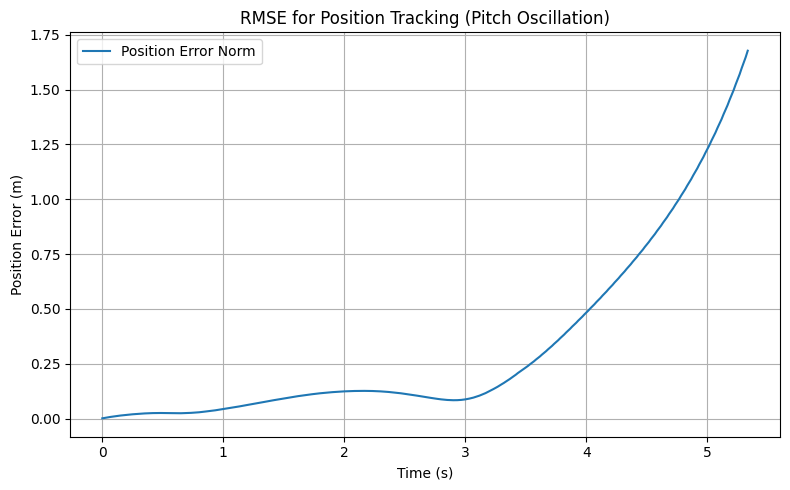

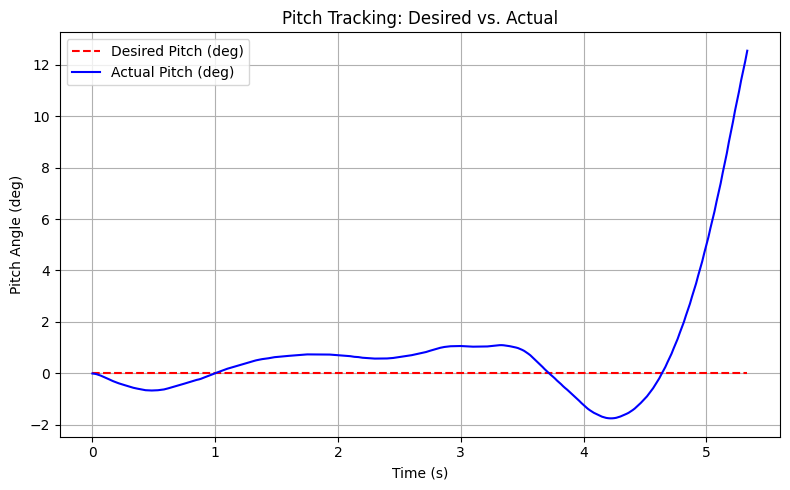

In [21]:
# ============================================================
# Crazyflie Pitch Oscillation with Hover Stability
# MuJoCo + Stable-Baselines3 DDPG + TensorBoard + RMSE
# ============================================================

import numpy as np
import mujoco
import gymnasium as gym
from gymnasium import spaces
from scipy.spatial.transform import Rotation as R
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.monitor import Monitor
import mediapy as media
import matplotlib.pyplot as plt

# ============================================================
# Parameters
# ============================================================
# OSC_AMP_DEG = 20.0      # smaller amplitude to ease learning
OSC_AMP_DEG = 0.0      # smaller amplitude to ease learning

OSC_FREQ_HZ = 0.125     # one cycle every 8 s
TRAIN_DUR_S = 32.0      # four full cycles
EVAL_DUR_S  = 16.0
DT = 1/60
LOG_DIR = "./ddpg_pitch_hover_logs/"
MODEL_PATH = "ddpg_pitch_hover_model"
XML_PATH = "bitcraze_crazyflie_2/cf2.xml"   # adjust if needed


# ============================================================
# Helper: wrap angle to [-pi, pi]
# ============================================================
def wrap_to_pi(x):
    return (x + np.pi) % (2 * np.pi) - np.pi


# ============================================================
# Helper: sinusoidal pitch reference
# ============================================================
def oscillation_reference(t, start_pos=(0.0, 0.0, 0.5),
                          amp_deg=OSC_AMP_DEG, freq=OSC_FREQ_HZ):
    """Hover in place, oscillate pitch about 0."""
    amp_rad = np.deg2rad(amp_deg)
    pitch = amp_rad * np.sin(2 * np.pi * freq * t)
    return np.array(start_pos), np.array([0.0, pitch, 0.0])


# ============================================================
# Environment
# ============================================================
class CrazyfliePitchEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 60}

    def __init__(self, duration=TRAIN_DUR_S, dt=DT, model_path=XML_PATH):
        super().__init__()

        self.dt = dt
        self.duration = duration
        self.num_steps = int(duration / dt)
        self.current_step = 0

        # Load MuJoCo model
        self.model = mujoco.MjModel.from_xml_path(model_path)
        self.data = mujoco.MjData(self.model)

        # Hover reference
        self.start_pos = np.array([0.0, 0.0, 0.5])
        self.mg = self.model.body("cf2").mass[0] * 9.81  # correct mg

        # Action: τx, τy, τz, thrust offset
        self.torque_limit = 0.03
        thrust_low = -self.mg
        thrust_high = 1.0 - self.mg
        low  = np.array([-self.torque_limit]*3 + [thrust_low], dtype=np.float32)
        high = np.array([ self.torque_limit]*3 + [thrust_high], dtype=np.float32)
        self.action_space = spaces.Box(low, high, dtype=np.float32)

        # Observation: pos(3), euler(3), vel(3), angvel(3)
        obs_low = np.array([-np.inf]*12, dtype=np.float32)
        obs_high = np.array([np.inf]*12, dtype=np.float32)
        obs_low[2] = 0.0
        obs_low[6:9] = -np.pi
        obs_high[6:9] = np.pi
        self.observation_space = spaces.Box(obs_low, obs_high, dtype=np.float32)

    # ------------------------------------------------------------
    # Gym API
    # ------------------------------------------------------------
    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        mujoco.mj_resetData(self.model, self.data)
        self.data.qpos[0:3] = self.start_pos.copy()
        self.data.qvel[:] = 0.0
        self.current_step = 0
        mujoco.mj_forward(self.model, self.data)
        return self._get_obs(), {}

    def step(self, action):
        action = np.clip(action, self.action_space.low, self.action_space.high)
        self.data.actuator("x_moment").ctrl = float(action[0]) * -1e5
        self.data.actuator("y_moment").ctrl = float(action[1]) * -1e5
        self.data.actuator("z_moment").ctrl = float(action[2]) * -1e5
        self.data.actuator("body_thrust").ctrl = float(action[3] + self.mg)

        # step physics
        target_time = (self.current_step + 1) * self.dt
        while self.data.time < target_time:
            mujoco.mj_step(self.model, self.data)
        self.current_step += 1

        obs = self._get_obs()
        reward = self._compute_reward()
        terminated = self.current_step >= self.num_steps
        truncated = self._has_crashed()
        return obs, reward, terminated, truncated, {}

    def render(self, mode="human"):
        with mujoco.Renderer(self.model, height=480, width=640) as renderer:
            renderer.update_scene(self.data, camera="track")
            return renderer.render()

    # ------------------------------------------------------------
    # Helpers
    # ------------------------------------------------------------
    def _get_obs(self):
        pos = self.data.qpos[0:3].copy()
        eul = R.from_quat(self.data.qpos[3:7], scalar_first=True).as_euler("xyz")
        eul = np.array([wrap_to_pi(e) for e in eul])
        vel = self.data.qvel[0:3].copy()
        ang_vel = self.data.qvel[3:6].copy()
        return np.concatenate([pos, eul, vel, ang_vel]).astype(np.float32)

    def _has_crashed(self):
        return bool(self.data.qpos[2] < 0.02 or abs(self.data.qpos[1]) > 1.0)

    def _get_tracking_error(self):
        t = self.current_step * self.dt
        ref_pos, ref_ori = oscillation_reference(t, self.start_pos)
        cur_pos = self.data.qpos[0:3].copy()
        cur_eul = R.from_quat(self.data.qpos[3:7], scalar_first=True).as_euler("xyz")
        cur_eul = np.array([wrap_to_pi(e) for e in cur_eul])
        pos_err = cur_pos - ref_pos
        ang_err = cur_eul - ref_ori
        return pos_err, ang_err

    # def _compute_reward(self):
    #     pos_err, ang_err = self._get_tracking_error()
    #     pos_err_norm = np.linalg.norm(pos_err)
    #     ang_err_norm = np.linalg.norm(ang_err)
    #     ang_vel_norm = np.linalg.norm(self.data.qvel[3:6])

    #     # smooth exponential reward
    #     # reward = np.exp(-6*pos_err_norm - 3*ang_err_norm - 0.2*ang_vel_norm)
    #     reward = np.exp(-8*pos_err_norm - 2*ang_err_norm - 0.1*ang_vel_norm) # for just hover


    #     # slight bonus if altitude within 10 cm and pitch close to target
    #     if abs(pos_err[2]) < 0.1 and abs(ang_err[1]) < np.deg2rad(5):
    #         reward += 0.05

    #     return float(reward)

    def _compute_reward(self):
        pos_err, ang_err = self._get_tracking_error()
        pos_err_norm = np.linalg.norm(pos_err)
        ang_err_norm = np.linalg.norm(ang_err)
        ang_vel_norm = np.linalg.norm(self.data.qvel[3:6])

        # smoother shaping
        base = np.exp(-6*pos_err_norm - 3*ang_err_norm - 0.2*ang_vel_norm)
        time_bonus = 0.001 * self.current_step              # survive longer = better
        reward = base + time_bonus

        # small hover bonus
        if abs(pos_err[2]) < 0.1 and abs(ang_err[1]) < np.deg2rad(5):
            reward += 0.05
        return float(reward)



# ============================================================
# Train + Evaluate
# ============================================================
if __name__ == "__main__":
    # Training env with monitor
    env = CrazyfliePitchEnv()
    env = Monitor(env)

    n_actions = env.action_space.shape[-1]
    action_noise = NormalActionNoise(
        mean=np.zeros(n_actions),
        sigma=0.05 * np.ones(n_actions)
    )

    ddpg = DDPG(
        "MlpPolicy",
        env,
        verbose=1,
        learning_rate=5e-4,
        buffer_size=300_000,
        learning_starts=10_000,
        batch_size=256,
        tau=0.005,
        gamma=0.98,
        train_freq=(100, "step"),
        gradient_steps=100,
        action_noise=action_noise,
        tensorboard_log=LOG_DIR,
    )

    ddpg.learn(total_timesteps=75_000, log_interval=10, tb_log_name="DDPG_pitch_hover_slight_oscillation")
    ddpg.save(MODEL_PATH)

    # -----------------------------
    # Evaluation
    # -----------------------------
    model = DDPG.load(MODEL_PATH)
    env_eval = CrazyfliePitchEnv(duration=EVAL_DUR_S)
    obs, _ = env_eval.reset()
    frames = []
    qpos_list, desired_pos_list, desired_pitch_list, actual_pitch_list, t_list = [], [], [], [], []

    for step in range(env_eval.num_steps):
        t = step * env_eval.dt
        ref_pos, ref_ori = oscillation_reference(t, env_eval.start_pos)

        action, _ = model.predict(obs, deterministic=True)
        obs, _, terminated, truncated, _ = env_eval.step(action)
        frame = env_eval.render()

        qpos_list.append(env_eval.data.qpos[:3].copy())
        desired_pos_list.append(ref_pos)
        desired_pitch_list.append(ref_ori[1])
        cur_eul = R.from_quat(env_eval.data.qpos[3:7], scalar_first=True).as_euler("xyz")
        actual_pitch_list.append(cur_eul[1])
        t_list.append(t)
        frames.append(frame)
        if terminated or truncated:
            break

    env_eval.close()
    media.show_video(frames, fps=int(1/DT))

    # RMSE
    qpos_arr = np.array(qpos_list)
    desired_pos_arr = np.array(desired_pos_list)
    error_norm = np.linalg.norm(qpos_arr - desired_pos_arr, axis=1)
    rms_error = np.sqrt(np.mean(error_norm**2))
    print(f"RMS Position Error (m): {rms_error:.4f}")

    # Plots
    plt.figure(figsize=(8,5))
    plt.plot(t_list, error_norm, label="Position Error Norm")
    plt.xlabel("Time (s)")
    plt.ylabel("Position Error (m)")
    plt.title("RMSE for Position Tracking (Pitch Oscillation)")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

    plt.figure(figsize=(8,5))
    plt.plot(t_list, np.rad2deg(desired_pitch_list), "r--", label="Desired Pitch (deg)")
    plt.plot(t_list, np.rad2deg(actual_pitch_list), "b", label="Actual Pitch (deg)")
    plt.xlabel("Time (s)")
    plt.ylabel("Pitch Angle (deg)")
    plt.title("Pitch Tracking: Desired vs. Actual")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


In [3]:
# Load the trained model
model = DDPG.load("ddpg_pitch_oscillation_model")

# Print full structure of the actor network
print(model.actor)

# Extract weights and biases
for name, param in model.actor.state_dict().items():
    print(f"{name}: {param.shape}")


Actor(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mu): Sequential(
    (0): Linear(in_features=12, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=300, bias=True)
    (3): ReLU()
    (4): Linear(in_features=300, out_features=4, bias=True)
    (5): Tanh()
  )
)
mu.0.weight: torch.Size([400, 12])
mu.0.bias: torch.Size([400])
mu.2.weight: torch.Size([300, 400])
mu.2.bias: torch.Size([300])
mu.4.weight: torch.Size([4, 300])
mu.4.bias: torch.Size([4])


In [4]:
import torch
import numpy as np

# Example: hover state with small pitch error
test_state = np.array([
    0.0, 0.0, 0.5,       # pos
    0.0, np.deg2rad(10), 0.0,  # euler angles (10° pitch)
    0.0, 0.0, 0.0,       # vel
    0.0, 0.0, 0.0        # body rates
], dtype=np.float32)

# Convert to PyTorch tensor
state_tensor = torch.tensor(test_state).unsqueeze(0)

# Get DDPG network output
action = model.actor.mu(state_tensor)
print("Network output (τx, τy, τz, fz):", action.detach().numpy())


Network output (τx, τy, τz, fz): [[-0.46749967  0.91422373 -0.9999622  -0.8108041 ]]


In [13]:
!pip install scikit-learn

In [11]:
from sklearn.linear_model import LinearRegression
import numpy as np

# sample small perturbations around hover
N = 1000
states = np.random.normal(0, 0.05, (N, 12)).astype(np.float32)
actions = np.zeros((N,4))
for i in range(N):
    s = torch.tensor(states[i]).unsqueeze(0)
    actions[i] = model.actor.mu(s).detach().numpy().squeeze()

reg = LinearRegression().fit(states, actions)
K = reg.coef_
b = reg.intercept_

print("Approximate linearized controller:")
for j,label in enumerate(["tau_x","tau_y","tau_z","f_z"]):
    eq = " + ".join([f"{K[j,i]:+.6f}*s{i}" for i in range(12)]) + f" {b[j]:+.6f}"
    print(f"{label} = {eq}")


Approximate linearized controller:
tau_x = -0.639121*s0 + -0.555746*s1 + -0.353056*s2 + -0.465004*s3 + +1.346235*s4 + -0.591034*s5 + -2.004411*s6 + -0.697647*s7 + +2.364541*s8 + -1.123325*s9 + +0.944223*s10 + +0.613414*s11 +0.109589
tau_y = +2.587014*s0 + -2.314780*s1 + -2.788328*s2 + -1.035190*s3 + +1.496446*s4 + +1.455584*s5 + +1.294895*s6 + -1.717565*s7 + +3.815091*s8 + -1.228325*s9 + +0.146283*s10 + +1.679400*s11 +0.318137
tau_z = -3.938852*s0 + -3.935937*s1 + +0.893014*s2 + -1.780304*s3 + +3.099274*s4 + -3.151364*s5 + -1.206140*s6 + -0.535411*s7 + -0.168387*s8 + -0.594395*s9 + +1.473236*s10 + -1.114614*s11 +0.568724
f_z = +2.312186*s0 + +2.111739*s1 + +0.057458*s2 + +1.966355*s3 + -0.711212*s4 + +3.096173*s5 + +4.094877*s6 + -0.574107*s7 + -1.351496*s8 + -0.164811*s9 + -0.536685*s10 + -1.286058*s11 -0.056807


In [ ]:
# where each s_i corresponds to your state terms (p_x, p_y, p_z, φ, θ, ψ, v_x, v_y, v_z, ω_x, ω_y, ω_z).

In [ ]:
tensorboard --logdir ./ddpg_oscillation_logs
